In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
from IPython.display import HTML
# http://blog.nextgenetics.net/?e=102
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### GLAO Point Spread Function
The point spread function is calculated using the structure function, given $C_n^2(z)$ profile and a constellation of guide stars.

The wavefront is reconstructed by averaging the guide star measurements:

$$\psi_r(x,\alpha) = \psi(x,\alpha) - \sum_{j=1}^{N_{\rm gs}} w_j \psi_j(x+\alpha z_c -\alpha_j z_s)$$

where $w_j$ is a vector of weights, typically each $1/N_{\rm gs}$. Chasing through the statistics of Kolmogorov turbulence effects on a GLAO corrected wavefront  yields an exact formulation for the atmospheric-averaged, or long-exposure, PSF.

The code implements equations (4), (8), and (58)-(59) in reference [1] to go from a $C_n^2$ profile to the PSF:

$$PSF(\theta) = \frac{1}{\lambda^2} \int MTF(x) e^{-i2\pi {\bf x} \cdot \theta / \lambda} \; d^2 x \qquad\qquad (4)$$

$$MTF_{ave}(u) = \tau_0(u) e^{-\frac{1}{2}{\cal D}_{\psi}(u)} \qquad\qquad (8)$$

$${\cal D}_{\psi_r}(r;\alpha) = \int C_N^2(z) {\bf w}^T {\bf S}(r; \alpha,z) {\bf w} dz \qquad \qquad (58)$$

$$s_{jj'}(r,\alpha,z) = \,2.914\,(\left | r+(\alpha_j-\alpha_{j'})(z-z_s) + \alpha(z_s-z_c)(\delta_{j,0}-\delta_{j',0}) \right |^{5/3}$$

$$\qquad \qquad \qquad \qquad \qquad - \left | (\alpha_j-\alpha_{j'})(z-z_s) + \alpha(z_s-z_c)(\delta_{j,0}-\delta_{j',0}) \right |^{5/3}) \qquad \qquad (59)$$

where $\alpha_i$, for $i=1\ldots N_{\rm gs}$ are the angular locations of the guide stars, $z_c$ is the conjugate altitude of the deformable mirror (which may be above or below 0km as in the case of an adaptive secondary), $z_s$ is the conjugate altitude of the wavefront sensor (typically 0km), and ${\bf w}$ is the vector of weights. The position of the field point, $\alpha$, is encoded in the vector of weights as $\alpha_0$, and with $w_0 = -1$.

** Reference **

[1] D. Gavel, *Point Spread Function for Ground Layer Adaptive Optics*, Report, 2017.

The software module defines two classes:
* Profile - definition of a $C_n^2(z)$ profile
* Constellation - definition of a guide star constellation

Ultimately, the two are connected in order to compute PSFs.


In [1]:
import paper2 as p
import numpy as np
from common_units import *

In [2]:
p.available()

---- In-code profiles: ----
CP Typical
MK Imaka
Cerro Pachon
Mauna Kea
Simple 1
Simple 2
Simple 2h_100

---- Profiles in Cn2_profiles.hd5 ----
Armazones 25%
Armazones median
Armazones 75%
Maunakea 13N 25%
Maunakea 13N median
Maunakea 13N 75%
ORM 25%
ORM median
ORM 75%


In [4]:
# This profile is from the Mattaias Schoek email
a = p.Cn2_Profile('Maunakea 13N median')
print a.h
print a.Cn2_bar
print a.r0, a.r00

[     0.    500.   1000.   2000.   4000.   8000.  16000.]
[ 0.45404624  0.14314616  0.05061932  0.04611891  0.11440958  0.08228737
  0.10937242]
0.211013714093 0.211013714093


In [9]:
a = p.Cn2_Profile('MK2009 50%')
print a.h
print a.Cn2_bar
print a.r0, a.r00

[    0.    15.    30.    45.   120.   200.   280.   360.   440.   520.
   600.  5000.]
[ 0.30153318  0.15424582  0.04088094  0.00183819  0.02107833  0.01017674
  0.00843713  0.0054218   0.00118874  0.          0.          0.45519913]
0.170685341847 0.170685341847


In [452]:
reload(p)
N = 4
rot = 45.
n = 256
a = p.Cn2_Profile('Maunakea 13N median')
radius = 5.
fieldpts = [0.,2.5,4.,5.]
zcs = [0,-280]
act_spacings = np.logspace(-1,2,15)*a.r0
PSFs = []
k = 0
K = len(act_spacings)*len(zcs)*len(fieldpts)
p.progress_bar(k,K)
for fieldpt in fieldpts:
    field_point = [fieldpt,0.]
    c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
    r_lim = a.r0*n/8.
    for zc in zcs:
        for act_spacing in act_spacings:
            a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
            w = np.zeros(N+1)
            w[0] = -1
            w[1:] = np.ones(N)/float(N)
            a.make_PSF(w)
            ena_rs.append(a.PSF.ena_r)
            PSFs.append(a.PSF)
            k = k+1
            p.progress_bar(k,K)
PSFs_MK4 = PSFs

[========================================] 100%

<IPython.core.display.Javascript object>


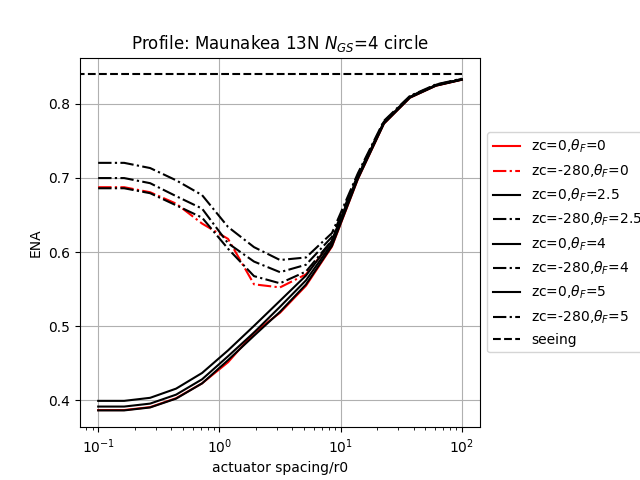

In [453]:
plt.figure()
enas = []
for PSF in PSFs_MK4:
    enas.append(PSF.ena)
PSF_seeing = a.PSF_seeing

ax = plt.subplot(111)
L = len(act_spacings)
k = 0
colors = ['r','k','k','k','k','g']
for fieldpt,color in zip(fieldpts,colors):
    for zc,lt in zip(zcs,['-','-.']):
        plt.plot(act_spacings/a.r0,enas[k*L:(k+1)*L],color+lt,label=r'zc=%d,$\theta_F$=%g'%(zc,fieldpt))
        k += 1
plt.xlabel('actuator spacing/r0')
plt.ylabel('ENA')
plt.grid('on')
plt.plot([0,act_spacings.max()/a.r0],[PSF_seeing.ena,]*2,'k--',label='seeing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Profile: Maunakea 13N $N_{GS}$=%d circle'%N)
plt.xscale('log')
plt.subplots_adjust(right=.75)

In [448]:
reload(p)
N = 4
rot = 45.
n = 256
a = p.Cn2_Profile('Simple 1')
radius = 5.
fieldpts = [0.,2.5,5.]
zcs = [0,-280]
act_spacings = np.logspace(-1,2,20)*a.r0
PSFs = []
k = 0
K = len(act_spacings)*len(zcs)*len(fieldpts)
p.progress_bar(k,K)
for fieldpt in fieldpts:
    field_point = [fieldpt,0.]
    c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
    r_lim = a.r0*n/8.
    for zc in zcs:
        for act_spacing in act_spacings:
            a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
            w = np.zeros(N+1)
            w[0] = -1
            w[1:] = np.ones(N)/float(N)
            a.make_PSF(w)
            ena_rs.append(a.PSF.ena_r)
            PSFs.append(a.PSF)
            k = k+1
            p.progress_bar(k,K)


[========================================] 100%

<IPython.core.display.Javascript object>


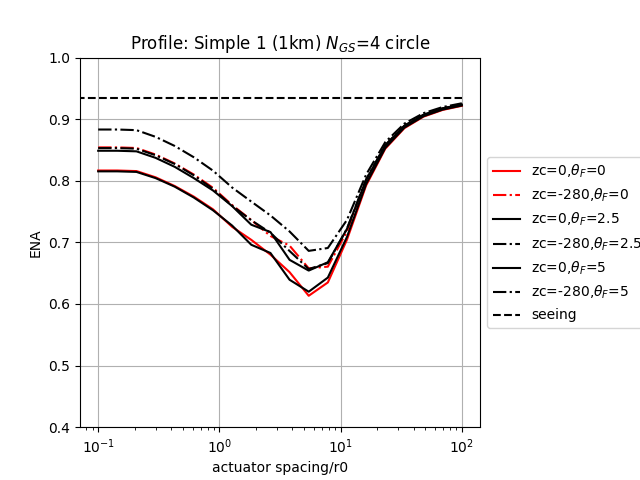

(0.4, 1.0)

In [449]:
plt.figure()
enas = []
for PSF in PSFs:
    enas.append(PSF.ena)
PSF_seeing = a.PSF_seeing

ax = plt.subplot(111)
L = len(act_spacings)
k = 0
colors = ['r','k','k','k','k','g']
for fieldpt,color in zip(fieldpts,colors):
    for zc,lt in zip(zcs,['-','-.']):
        plt.plot(act_spacings/a.r0,enas[k*L:(k+1)*L],color+lt,label=r'zc=%d,$\theta_F$=%g'%(zc,fieldpt))
        k += 1
plt.xlabel('actuator spacing/r0')
plt.ylabel('ENA')
plt.grid('on')
plt.plot([0,act_spacings.max()/a.r0],[PSF_seeing.ena,]*2,'k--',label='seeing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Profile: %s (1km) $N_{GS}$=%d circle'%(a.name,N))
plt.xscale('log')
plt.subplots_adjust(right=.75)
plt.ylim(.4,1.)

In [446]:
reload(p)
N = 4
rot = 45.
n = 256
layer_height = 5.
a = p.Cn2_Profile('Simple 1',layer_height=layer_height)
radius = 5.
fieldpts = [0.,2.5,5.]
zcs = [0,-280]
act_spacings = np.logspace(-1,2,20)*a.r0
PSFs = []
k = 0
K = len(act_spacings)*len(zcs)*len(fieldpts)
p.progress_bar(k,K)
for fieldpt in fieldpts:
    field_point = [fieldpt,0.]
    c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
    r_lim = a.r0*n/8.
    for zc in zcs:
        for act_spacing in act_spacings:
            a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
            w = np.zeros(N+1)
            w[0] = -1
            w[1:] = np.ones(N)/float(N)
            a.make_PSF(w)
            ena_rs.append(a.PSF.ena_r)
            PSFs.append(a.PSF)
            k = k+1
            p.progress_bar(k,K)


[========================================] 100%

<IPython.core.display.Javascript object>


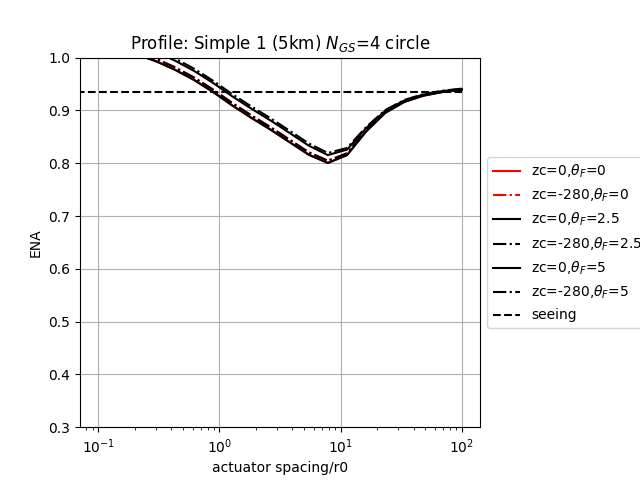

(0.3, 1.0)

In [447]:
plt.figure()
enas = []
for PSF in PSFs:
    enas.append(PSF.ena)
PSF_seeing = a.PSF_seeing

ax = plt.subplot(111)
L = len(act_spacings)
k = 0
colors = ['r','k','k','k','k','g']
for fieldpt,color in zip(fieldpts,colors):
    for zc,lt in zip(zcs,['-','-.']):
        plt.plot(act_spacings/a.r0,enas[k*L:(k+1)*L],color+lt,label=r'zc=%d,$\theta_F$=%g'%(zc,fieldpt))
        k += 1
plt.xlabel('actuator spacing/r0')
plt.ylabel('ENA')
plt.grid('on')
plt.plot([0,act_spacings.max()/a.r0],[PSF_seeing.ena,]*2,'k--',label='seeing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Profile: %s (%gkm) $N_{GS}$=%d circle'%(a.name,layer_height,N))
plt.xscale('log')
plt.subplots_adjust(right=.75)
plt.ylim(.3,1.)

In [450]:
reload(p)
N = 4
rot = 45.
n = 256
layer_height = 0.3 # km
a = p.Cn2_Profile('Simple 1',layer_height=layer_height)
radius = 5.
fieldpts = [0.,2.5,5.]
zcs = [0,-280]
act_spacings = np.logspace(-1,2,20)*a.r0
PSFs = []
k = 0
K = len(act_spacings)*len(zcs)*len(fieldpts)
p.progress_bar(k,K)
for fieldpt in fieldpts:
    field_point = [fieldpt,0.]
    c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
    r_lim = a.r0*n/8.
    for zc in zcs:
        for act_spacing in act_spacings:
            a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
            w = np.zeros(N+1)
            w[0] = -1
            w[1:] = np.ones(N)/float(N)
            a.make_PSF(w)
            ena_rs.append(a.PSF.ena_r)
            PSFs.append(a.PSF)
            k = k+1
            p.progress_bar(k,K)


[========================================] 100%

<IPython.core.display.Javascript object>


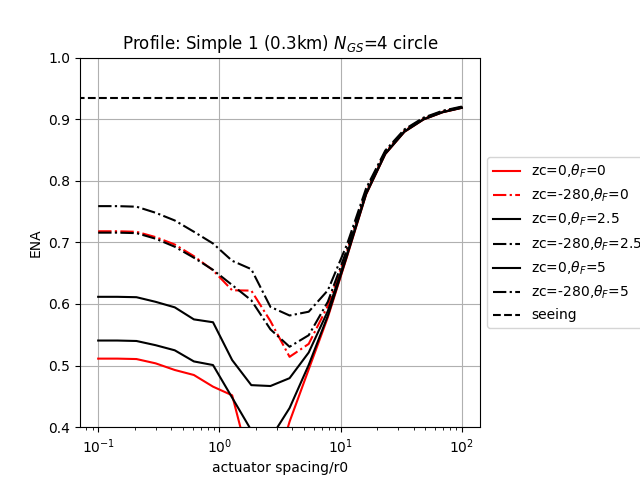

(0.4, 1.0)

In [451]:
plt.figure()
enas = []
for PSF in PSFs:
    enas.append(PSF.ena)
PSF_seeing = a.PSF_seeing

ax = plt.subplot(111)
L = len(act_spacings)
k = 0
colors = ['r','k','k','k','k','g']
for fieldpt,color in zip(fieldpts,colors):
    for zc,lt in zip(zcs,['-','-.']):
        plt.plot(act_spacings/a.r0,enas[k*L:(k+1)*L],color+lt,label=r'zc=%d,$\theta_F$=%g'%(zc,fieldpt))
        k += 1
plt.xlabel('actuator spacing/r0')
plt.ylabel('ENA')
plt.grid('on')
plt.plot([0,act_spacings.max()/a.r0],[PSF_seeing.ena,]*2,'k--',label='seeing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Profile: %s (%gkm) $N_{GS}$=%d circle'%(a.name,layer_height,N))
plt.xscale('log')
plt.subplots_adjust(right=.75)
plt.ylim(.4,1.)

In [444]:
reload(p)
N = 4
rot = 45.
n = 256
layer_height = 0.3 # km
a = p.Cn2_Profile('Simple 1',layer_height=layer_height)
radius = 5.
fieldpts = [2.5]
zcs = [0,-280]
act_spacings = np.logspace(-1,3.5,20)*a.r0
PSFs = []
k = 0
K = len(act_spacings)*len(zcs)*len(fieldpts)
p.progress_bar(k,K)
for fieldpt in fieldpts:
    field_point = [fieldpt,0.]
    c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
    r_lim = a.r0*n/8.
    for zc in zcs:
        for act_spacing in act_spacings:
            a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
            w = np.zeros(N+1)
            w[0] = -1
            w[1:] = np.ones(N)/float(N)
            a.make_PSF(w)
            ena_rs.append(a.PSF.ena_r)
            PSFs.append(a.PSF)
            k = k+1
            p.progress_bar(k,K)


[========================================] 100%

<IPython.core.display.Javascript object>


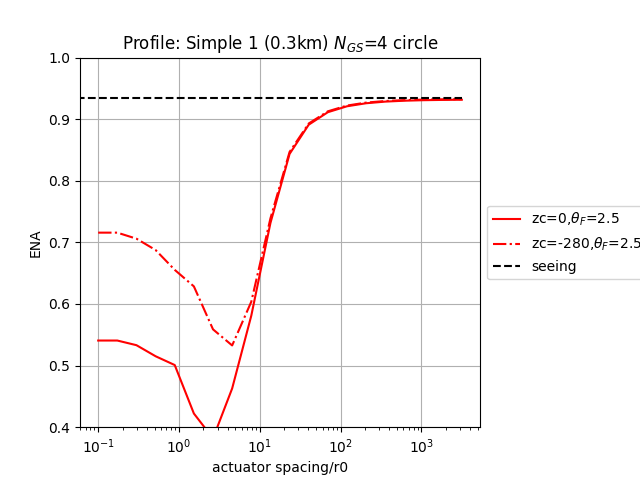

(0.4, 1.0)

In [445]:
plt.figure()
enas = []
for PSF in PSFs:
    enas.append(PSF.ena)
PSF_seeing = a.PSF_seeing

ax = plt.subplot(111)
L = len(act_spacings)
k = 0
colors = ['r','k','k','k','k','g']
for fieldpt,color in zip(fieldpts,colors):
    for zc,lt in zip(zcs,['-','-.']):
        plt.plot(act_spacings/a.r0,enas[k*L:(k+1)*L],color+lt,label=r'zc=%d,$\theta_F$=%g'%(zc,fieldpt))
        k += 1
plt.xlabel('actuator spacing/r0')
plt.ylabel('ENA')
plt.grid('on')
plt.plot([0,act_spacings.max()/a.r0],[PSF_seeing.ena,]*2,'k--',label='seeing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Profile: %s (%gkm) $N_{GS}$=%d circle'%(a.name,layer_height,N))
plt.xscale('log')
plt.subplots_adjust(right=.75)
plt.ylim(.4,1.)

<IPython.core.display.Javascript object>


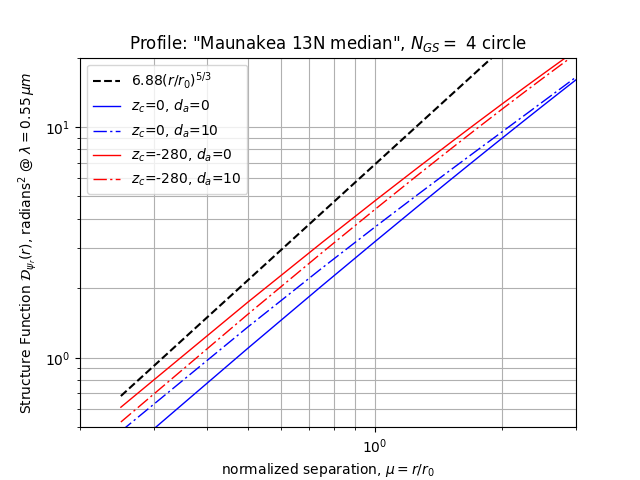

(0.5, 20)

In [239]:
reload(p)
N = 4
rot = 45.
n = 256
a = p.Cn2_Profile('Maunakea 13N median')
radius = 5.
field_point = [4.,0.]
plt.figure()
zcs = [0,-280]
act_spacings = np.array([0.,10.])*a.r0
over = False
for zc in zcs:
    color = ['red','blue'][zc == zcs[0]]
    for act_spacing in act_spacings:
        linestyle = ['-','-.'][act_spacing > 0]
        c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
        r_lim = a.r0*n/8.
        a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
        w = np.zeros(N+1)
        w[0] = -1
        w[1:] = np.ones(N)/float(N)
        a.make_PSF(w)
        a.graph(normalized_r=True,over=over,color=color,linestyle=linestyle,linewidth=1,label=r'$z_c$=%g, $d_a$=%g'%(zc,act_spacing/a.r0))
        over = True
plt.legend()
plt.xlim(.2,3)
plt.ylim(5e-1,20)

<IPython.core.display.Javascript object>


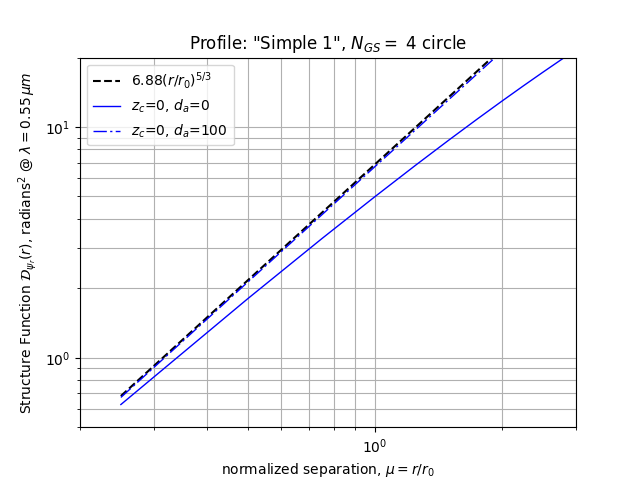

Debug: zc = 0, no filter
False
Debug: zc = 0, filter at 20 r0
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


(0.5, 20)

In [397]:
reload(p)
import copy
N = 4
rot = 45.
n = 256
profile = 'Maunakea 13N median'
profile = 'Simple 1'
a = p.Cn2_Profile(profile)
radius = 5.
field_point = [3.,0.]
plt.figure()
zcs = [0]
act_spacings = np.array([0.,100.])*a.r0
over = False
aset = []
for zc in zcs:
    color = ['red','blue'][zc == zcs[0]]
    for act_spacing in act_spacings:
        linestyle = ['-','-.'][act_spacing > 0]
        c = p.Constellation(N,radius,'circle',rot=rot,field_point = field_point)
        r_lim = a.r0*n/8.
        asp = [None,act_spacing][act_spacing > 0]
        if asp is None:
            print 'Debug: zc = %g, no filter'%(zc)
        else:
            print 'Debug: zc = %g, filter at %g r0'%(zc,act_spacing)
        a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = asp)
        w = np.zeros(N+1)
        w[0] = -1
        w[1:] = np.ones(N)/float(N)
        a.make_PSF(w)
        a.graph(normalized_r=True,over=over,color=color,linestyle=linestyle,linewidth=1,label=r'$z_c$=%g, $d_a$=%g'%(zc,act_spacing/a.r0))
        over = True
        aset.append(copy.deepcopy(a))
        print a.spatialFilter
plt.legend()
plt.xlim(.2,3)
plt.ylim(5e-1,20)

In [379]:
for a in aset:
    print 'S_original'
    print a.S_original[:,:,n/2,n/2+1]
    print 'S_final'
    print a.S[:,:,n/2,n/2+1]
    print 'D'
    print a.D[n/2,n/2+1]
    print '*'*60

S_original
[[  0.68258245  12.44129867  12.44129867  -1.08263525  -1.08263525]
 [-12.20069545   0.68258245   0.16479058 -11.95187519 -13.44310364]
 [-12.20069545   0.16479058   0.68258245 -13.44310364 -11.95187519]
 [  1.49317047  12.19657699  13.66284005   0.68258245   0.16479058]
 [  1.49317047  13.66284005  12.19657699   0.16479058   0.68258245]]
S_final
[[  0.68258245  12.44129867  12.44129867  -1.08263525  -1.08263525]
 [-12.20069545   0.68258245   0.16479058 -11.95187519 -13.44310364]
 [-12.20069545   0.16479058   0.68258245 -13.44310364 -11.95187519]
 [  1.49317047  12.19657699  13.66284005   0.68258245   0.16479058]
 [  1.49317047  13.66284005  12.19657699   0.16479058   0.68258245]]
D
0.626911270942
************************************************************
S_original
[[  0.68258245  12.44129867  12.44129867  -1.08263525  -1.08263525]
 [-12.20069545   0.68258245   0.16479058 -11.95187519 -13.44310364]
 [-12.20069545   0.16479058   0.68258245 -13.44310364 -11.95187519]
 [  1.

<IPython.core.display.Javascript object>


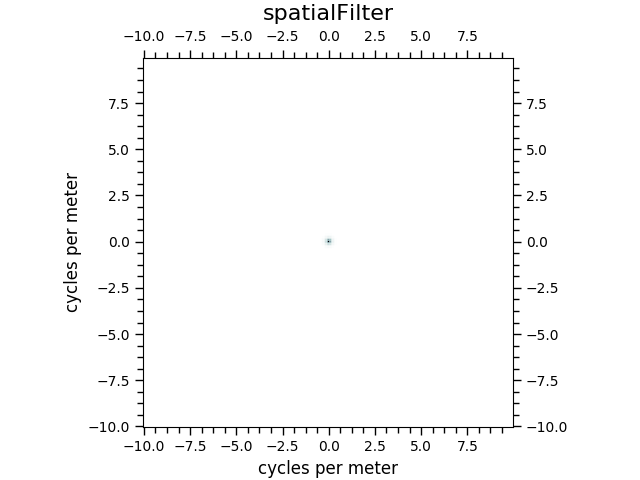

0.935836123595


In [398]:
aset[1].spatialFilter.show()
print aset[1].spatialFilter.min()

In [279]:
a = aset[1]
a.dr,a.dr*a.n_fine

(0.049999999999999822, 12.799999999999955)

<IPython.core.display.Javascript object>


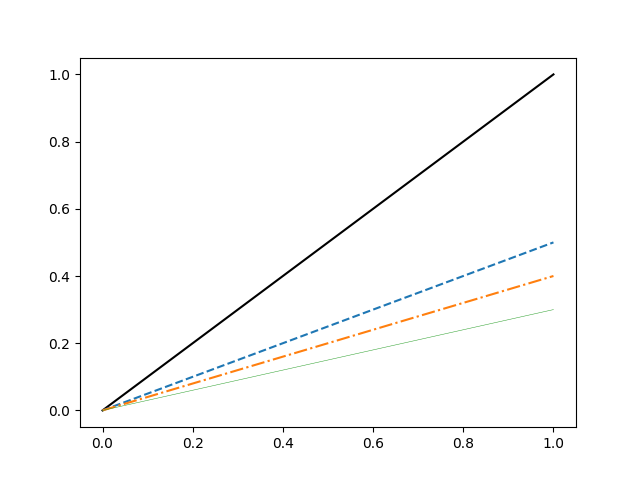

In [214]:
plt.figure()
plt.plot([0,1],[0,1],color='k')
plt.plot([0,1],[0,.5],linestyle='--',color=None)
plt.plot([0,1],[0,.4],linestyle='-.',linewidth=None,color=None)
plt.plot([0,1],[0,.3],linestyle='default',linewidth=.35,color=None)

In [268]:
a.r_x

array([[-6.4 , -6.35, -6.3 , ...,  6.25,  6.3 ,  6.35],
       [-6.4 , -6.35, -6.3 , ...,  6.25,  6.3 ,  6.35],
       [-6.4 , -6.35, -6.3 , ...,  6.25,  6.3 ,  6.35],
       ..., 
       [-6.4 , -6.35, -6.3 , ...,  6.25,  6.3 ,  6.35],
       [-6.4 , -6.35, -6.3 , ...,  6.25,  6.3 ,  6.35],
       [-6.4 , -6.35, -6.3 , ...,  6.25,  6.3 ,  6.35]])

In [296]:
a.pprint()
a.constellation.pprint()

<class 'paper2.Cn2_Profile'> Single layer atmosphere
------------------------------------------------------------
C:    <type 'numpy.ndarray'> (256, 256)
Cn2:    [  2.64834940e-13] m^1/3 (Cn2*dh units)
Cn2_bar:    [ 1.]
D:    <type 'numpy.ndarray'> (256, 256)
MTF:    <class 'info_array.InfoArray'> (256, 256) 'MTF'
MTF_dl:    <class 'info_array.InfoArray'> (512, 512) '${\rm MTF}_{\rm dl}$'
MTF_seeing:    <class 'info_array.InfoArray'> (512, 512) '${\rm MTF}_{\rm seeing}$'
PSF:    <class 'info_array.InfoArray'> (256, 256) 'PSF'
PSF_dl:    <class 'info_array.InfoArray'> (512, 512) '${\rm PSF}_{\rm dl}$'
PSF_seeing:    <class 'info_array.InfoArray'> (512, 512) '${\rm PSF}_{\rm seeing}$'
S:    <type 'numpy.ndarray'> (5, 5, 256, 256)
S0:    <type 'numpy.ndarray'> (5, 5, 256, 256)
S_seeing:    <type 'numpy.ndarray'> (512, 512)
act_spacing:    0.1 m
constellation:    <paper2.Constellation object at 0x152c84c50> 'Guide star constellation'
dm_conjugate:    0 m
dmu:    0.25
dr:    0.05 m
dth:    

<IPython.core.display.Javascript object>


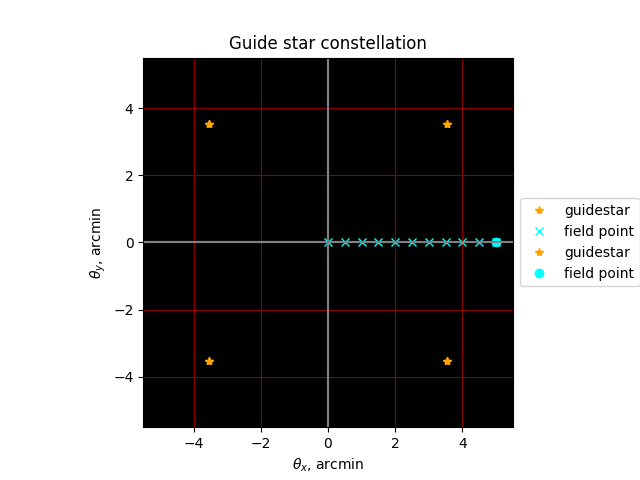

In [95]:
def _graph(self,field_points = None):
    """Graph the constellation of guidestars and the field point
    Keyword:
        Field_points = a list of [x,y] field points to graph instead of the one associated with the constellation
    """
    x,y = self.alpha.transpose()/arcmin
    r = max(np.abs(x).max(),np.abs(y).max())*1.1
    plt.plot(x[1:],y[1:],'*',color='orange',label='guidestar')
    if field_points is None:
        plt.plot(x[0],y[0],'o',color='cyan',label='field point')
    else:
        label = 'field point'
        for point in field_points:
            plt.plot(point[0],point[1],'x',color='cyan',label=label)
            label = None
    plt.xlim(-r,r)
    plt.ylim(-r,r)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axes().set_aspect('equal')
    plt.grid('on',color='darkred')
    plt.plot([-r,r],[0,0],'grey')
    plt.plot([0,0],[-r,r],'grey')
    plt.gca().set_facecolor("black")
    plt.xlabel(r'$\theta_x$, arcmin')
    plt.ylabel(r'$\theta_y$, arcmin')
    plt.title(self.name)

plt.figure()
self = a.constellation
r = np.arange(0,5.1,.5)
fp = zip(r,np.zeros(len(r)))
_graph(self,field_points = fp)
_graph(self)


<IPython.core.display.Javascript object>


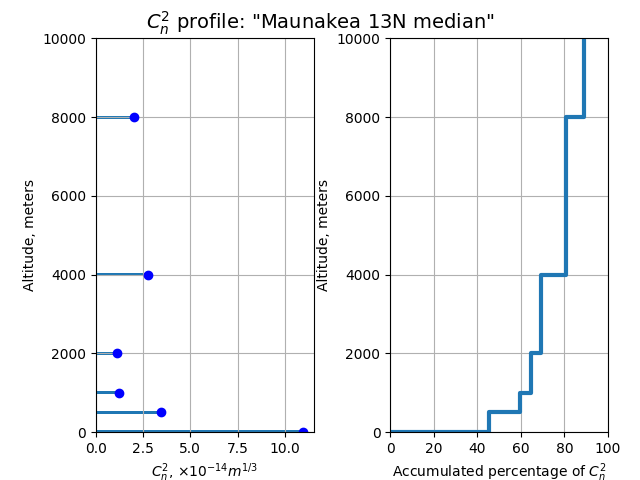

In [114]:
def _profile_plot(self,altscale='log',cn2scale='log',drawstyle='steps'):
    """plot the profile and cumulative Cn2 profile
    Keywords:
        altscale - altitude scale; can be 'linear' or 'log'
        cn2scale - Cn2 axis scale; can be 'linear' or 'log'
        drawstyle - draw style for the cumulative graph: can be 'default' or 'steps'
        (Cn2 draw style is bar, with dot at end)
    """
    h,Cn2,Cn2_bar = self.h, self.Cn2, self.Cn2_bar
    cumProfile = []
    a = 0.
    for c in Cn2_bar:
        a += c
        cumProfile.append(a)
    cumProfile = np.array(cumProfile)

    plt.subplot(121)
    if altscale == 'log':
        plt.barh(h,Cn2/10**(-14),log=True,height=h*.05)
    else:
        plt.barh(h,Cn2/10**(-14),height = h.max()*.005)
    plt.plot(Cn2/10**(-14),h,'bo')
    plt.xlabel(r'$C_n^2$, $\times 10^{-14} m^{1/3}$')
    plt.ylabel('Altitude, meters')
    plt.yscale(altscale)
    plt.xscale(cn2scale)
    plt.ylim(0.9,10000.)
    plt.grid('on')

    plt.subplot(122)
    cumProfile = np.append([0],cumProfile)
    h = np.append([.9],h)
    plt.plot(cumProfile*100,h,linewidth=3,drawstyle=drawstyle)
    plt.xlabel(r'Accumulated percentage of $C_n^2$')
    plt.ylabel('Altitude, meters')
    plt.ylim(0.9,10000.)
    plt.yscale(altscale)
    plt.xlim(0,100)
    plt.grid('on')
    plt.subplots_adjust(top=0.92,bottom=0.1, left=0.15,right=0.95,hspace=0.25,wspace=0.35)        

    plt.suptitle(r'$C_n^2$ profile: "%s"'%self.kind,fontsize=14)

plt.figure()
_profile_plot(a,altscale='linear',cn2scale='linear')

<IPython.core.display.Javascript object>


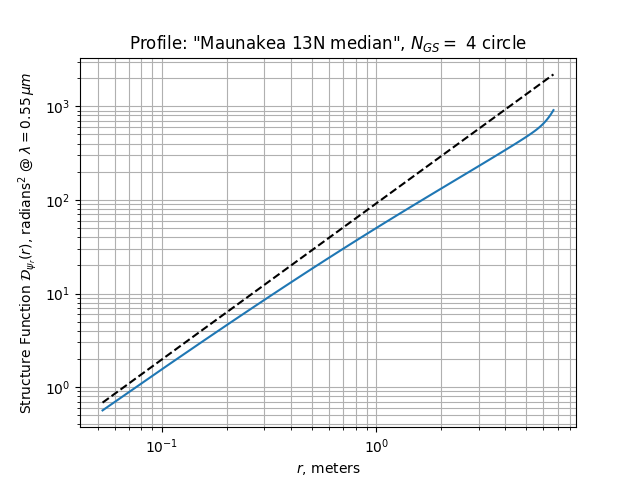

In [118]:
from common_units import *
def _graph(self, which='structure',type='line',over=False,label='',dots=False, normalized_r=False):
    """graph one of the characteristic functions, Structure function or Correlation function.

    keyword:
        which - 'structure' or 'correlation'
        type - the type of graph, either 'line' (lineout) or 'grey' (2-d image greyscale)
        over - for lineout, this allows multiple overplots. First call should be False, then True for subsequent overplots
        label - if multiple overplots, the text for a legend (call plt.legend() after the last overplot)
    """
    assert which in ['structure','correlation']
    assert type in ['line','grey']

    n,n = self.D.shape
    title = 'Profile: "%s", $N_{GS} =$ %d %s'%(self.name,self.constellation.N,self.constellation.geometry)
    if which == 'structure':
        P = self.D
        ylabel = r'Structure Function ${\cal D}_{\psi_r}(r)$, radians$^2$ @ $\lambda = %0.2f\, {\mu}m$'%(self.lam*units[self.lam_units]/microns)
    elif which == 'correlation':
        P = self.C
        ylabel = r'Correlation Function ${\cal C}_{\psi_r}(r)$, radians$^2$'
    if normalized_r:
        xlabel = r'normalized separation, $\mu=r/r_0$'
    else:
        xlabel = r'$r$, meters'
    if type == 'line':
        P = P[n/2,n/2+1:]
        r = self.r_x[n/2,n/2+1:]
        mu = self.mu_x[n/2,n/2+1:]
        if normalized_r:
            r = mu
        if which == 'structure' and not over:
            label0 = r'$6.88(r/r_0)^{5/3}$'
            plt.plot(r,6.88*mu**(5./3.),'k--',label=label0)                
        line, = plt.plot(r,P,'-',label=label)
        color = line.get_color()
        if dots: plt.plot(r,P,'.',color=color)
        if which == 'structure':
            plt.xscale('log')
            plt.yscale('log')
        if not over:
            plt.grid('on',which='both')
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
    elif type == 'grey':
        print 'type=grey not implemented yet'

plt.figure()
_graph(a)

In [117]:
a.lam,a.lam_units,p.units[a.lam_units]

(0.55, 'microns', 1e-06)

In [127]:
reload(p)
N = 4
n = 256
a = p.Cn2_Profile('ORM median')
radius = 5.
c = p.Constellation(N,radius,'circle')
r_lim = a.r0*n/8.
n_acts_across = 36
D_tele = 30.
ena_rs = []
PSFs = []
k = 0
act_spacings = np.arange(0,41)*a.r0
act_spacings = np.linspace(0,500,15)*a.r0
act_spacings = np.logspace(-1,3,15)*a.r0
zcs = [0,-280]
K = len(act_spacings)*len(zcs)
for zc in zcs:
    for act_spacing in act_spacings:
        a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
        w = np.zeros(N+1)
        w[0] = -1
        w[1:] = np.ones(N)/float(N)
        a.make_PSF(w)
        ena_rs.append(a.PSF.ena_r)
        PSFs.append(a.PSF)
        k = k+1
        p.progress_bar(k,K)
PSFs_ORM4 = PSFs


[==============================] 100%

### Plot vs wavelength

In [22]:
reload(p)
lams = np.array([0.4, 0.6, 0.7, 1.0, 1.6, 2.0]) # microns
PSFs = []
PSFseeings = []
N = 4
rot = 45.
n = 256
profile = 'Maunakea 13N median'
radius = 5.
field_point = [3.,0.]
c = p.Constellation(N,radius,'circle')
zc = -280
K = len(lams)
k = 0
p.progress_bar(k,K)

for lam in lams:
    a = p.Cn2_Profile(profile,lam=lam)
    act_spacing = 4.*a.r00
    a.make_S(c,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
    w = np.zeros(N+1)
    w[0] = -1
    w[1:] = np.ones(N)/float(N)
    a.make_PSF(w)
    PSFs.append(a.PSF)
    PSFseeings.append(a.PSF_seeing)
    k = k+1
    p.progress_bar(k,K)


[      ] 0%WARNING: structure function extent 4.61 arcmin is less than constellation radius 7.43 arcmin at h_bar
suggest increasing n (now 256) to >412
[======] 100%

In [16]:
PSFseeings[1].pprint()

${\rm PSF}_{\rm seeing}$
<class 'info_array.InfoArray'>
shape: (512, 512)
axis_names:    ['$\\theta_x$', '$\\theta_y$']
dx:    0.00412771267713 arcsec
ena:    0.810663626788 arcsec^2
ena_r:    0.507978588895 ENA radius, arcsec
name:    '${\rm PSF}_{\rm seeing}$'
plotParams:    <type 'dict'>
sub:    <type 'str'>
units:    ''
wavelength:    0.6 microns


<IPython.core.display.Javascript object>


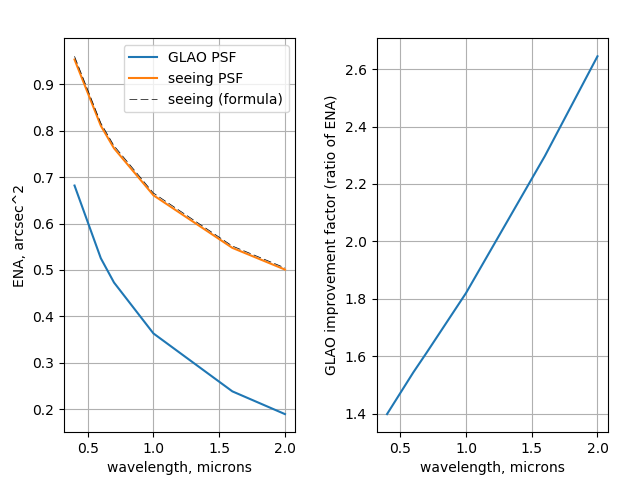

In [33]:
plt.figure()

enas = []
ena_seeings = []
r = []
ena_comps = []
for PSF,PSF0 in zip(PSFs,PSFseeings):
    enas.append(PSF.ena)
    ena_seeings.append(PSF0.ena)
    r.append( PSF0.ena/PSF.ena )
    ena_comps.append(2.92514*((PSF.wavelength*microns)/PSF.r0/arcsec)**2)
    
plt.subplot(121)
plt.plot(lams,enas,label='GLAO PSF')
plt.plot(lams,ena_seeings,label='seeing PSF')
plt.plot(lams,ena_comps,'k--',linewidth=.5,label='seeing (formula)')

plt.xlabel('wavelength, microns')
plt.ylabel('ENA, arcsec^2')
plt.grid('on')
plt.legend()

plt.subplot(122)
plt.plot(lams,r)
plt.xlabel('wavelength, microns')
plt.ylabel('GLAO improvement factor (ratio of ENA)')
plt.grid('on')
plt.subplots_adjust(top=0.92,bottom=0.1, left=0.10,right=0.95,hspace=0.25,wspace=0.35) 

In [41]:
a = p.Cn2_Profile(profile,lam=0.5)
[a.lam,a.r0,(a.lam*microns/a.r0/arcsec)**2*2.92514]

[0.5, 0.18820859795287997, 0.87833059886645848]

<IPython.core.display.Javascript object>


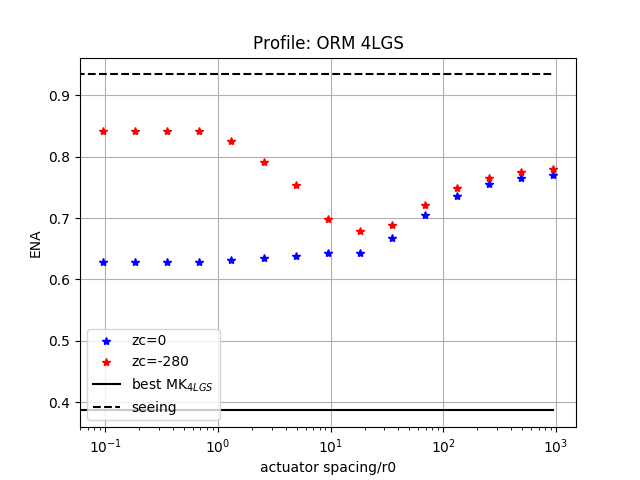

In [149]:
plt.figure()

enas = []
for PSF in PSFs_ORM4:
    enas.append(PSF.ena)
PSF_seeing = PSF_seeing_ORM

ax = plt.subplot(111)
plt.plot(act_spacings/a.r0,enas[0:len(act_spacings)],'b*',label='zc=0')
plt.plot(act_spacings/a.r0,enas[len(act_spacings):K],'r*',label='zc=-280')
plt.xlabel('actuator spacing/r0')
plt.ylabel('ENA')
plt.grid('on')
plt.plot([0,act_spacings.max()/a.r0],[ena_base4,]*2,'k-',label=r'best MK$_{4LGS}$')
plt.plot([0,act_spacings.max()/a.r0],[PSF_seeing.ena,]*2,'k--',label='seeing')
plt.legend()
plt.title('Profile: ORM 4LGS')
plt.xscale('log')

In [130]:
PSF_seeing_ORM = a.PSF_seeing

In [131]:
N = 4
n = 256
a = p.Cn2_Profile('Maunakea 13N median')
radius = 5.
c = p.Constellation(N,radius,'circle')
r_lim = a.r0*n/8.
act_spacing = 0.
zc = 0.
a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=zc,wfs_conjugate=zc, act_spacing = act_spacing)
w = np.zeros(N+1)
w[0] = -1
w[1:] = np.ones(N)/float(N)
a.make_PSF(w)
PSF_seeing_MK = a.PSF_seeing

<IPython.core.display.Javascript object>


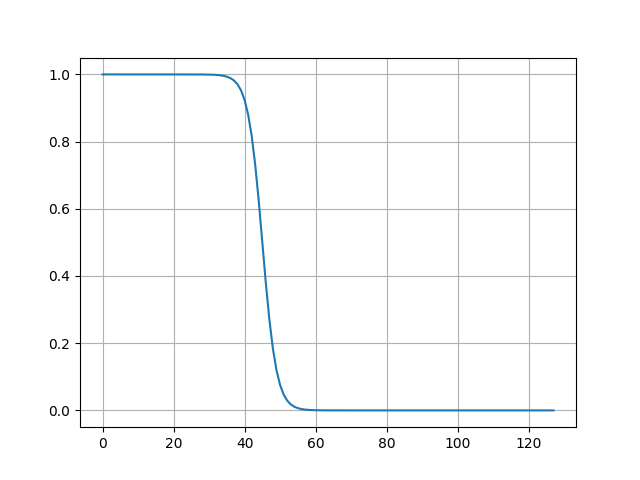

In [439]:
x = np.arange(0,128)
dx = 2.
x0 = 40.+2.5*dx
f = 1. / (1. + np.exp((x-x0)/dx))
plt.figure()
plt.plot(x,f)
plt.grid()

In [9]:
reload(p)
N = 3
n = 256
a = p.Cn2_Profile('MK Imaka')
csize = 10.
c = p.Constellation(N,csize,'circle')
r_lim = a.r0*n/8
a.make_S(c,r_lim=r_lim,n=n,dm_conjugate=0.)
w = np.zeros(N+1)
w[0] = -1
w[1:] = np.ones(N)/float(N)
a.make_PSF(w)
u = np.arange(-n/2,n/2)*a.dr
th = np.arange(-n/2,n/2)*a.lam*microns/(n*a.dr)/arcsec

In [10]:
plt.plot(a.PSF[n/2,:])

In [74]:
reload(p)
df = p.test2(model='MK Imaka',cycle='csize',cases=[10.,20.,40.,50.,120.])
df

_ _ _ _ _ 
. . . . .

model    curve  csize    N     nx  \
0  MK Imaka     GLAO   10.0  3.0  256.0   
1  MK Imaka     GLAO   20.0  3.0  256.0   
2  MK Imaka     GLAO   40.0  3.0  256.0   
3  MK Imaka     GLAO   50.0  3.0  256.0   
4  MK Imaka     GLAO  120.0  3.0  256.0   
5  MK Imaka   seeing    0.0  0.0  256.0   
6   diffLim  diffLim    0.0  0.0  256.0   

                                                 mtf  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                   u  \
0  [-6.85135798241, -6.79783174817, -6.7443055139...   
1  [-6.85135798241, -6.79783174817, -6.7443055139...   
2  [-6.85135798241, -6.79783174817, -6.7443055139...   
3  [-6.85135798241, -6.79783174817, -6.7443055139...   
4  [-6.85135798241, -6.79783174817, -6.7443055139...   
5  [-6.85135798241, -6.79783174817, -6.7443055139...   
6  [-6.85135798241, -6.79783174817, -6.7443055139...   

                                                 psf  \
0  [7.72542764764e-06, 7.87158817729e-06, 7.92447...   
1  [2.53412146079e-05, 2.54976065133e-05, 2.56957...   
2  [0.000118728089643, 0.000118757295703, 0.00011...   
3  [0.00016928650424, 0.000169282419178, 0.000169...   
4  [0.000583524184371, 0.000583582509679, 0.00058...   
5  [0.00777987458805, 0.00778514734204, 0.0078009...   
6  [1.70939247218e-06, 1.86360636149e-06, 1.93177...   

                                               theta  
0  [-1.05972001442, -1.0514409518, -1.04316188919...  
1  [-1.05972001442, -1.0514409518, -1.04316188919...  
2  [-1.05972001442, -1.0514409518, -1.04316188919...  
3  [-1.05972001442, -1.0514409518, -1.04316188919...  
4  [-1.05972001442, -1.0514409518, -1.04316188919...  
5  [-1.05972001442, -1.0514409518, -1.04316188919...  
6  [-1.05972001442, -1.0514409518, -1.04316188919...

<IPython.core.display.Javascript object>


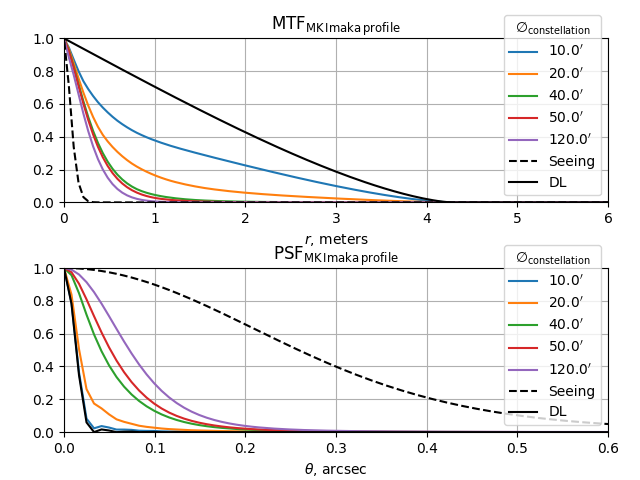

In [8]:
reload(p)
plt.figure()
p.test2_plot(dflo)
plt.subplots_adjust(top=0.92,bottom=0.1, left=0.10,right=0.95,hspace=0.4,wspace=0.35)
plt.subplot(212)
plt.xlim(0,.6)
plt.ylim(.001,1)
plt.yscale('linear')

In [80]:
# Save the data
import time
store = pd.HDFStore('paper2.hd5')
metadata = {'descr':'MTF and PSF lineouts for various star constellations',
           'time':time.strftime('%Y/%m/%dT%H:%M:%S')}
if 'dflo' in store:
    print 'WARNING: dflo is already in the store. opting to not over-write'
else:
    store['dflo'] = df
    store.get_storer('dflo').attrs.metadata = metadata
store.close()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['model', 'curve', 'mtf', 'u', 'psf', 'theta']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [81]:
# get the data
store = pd.HDFStore('paper2.hd5')
df2 = store['dflo']
metadata = store.get_storer('dflo').attrs.metadata
store.close()
print metadata
df2

{'descr': 'MTF and PSF lineouts for various star constellations', 'time': '2017/04/27T12:04:59'}


model    curve  csize    N     nx  \
0  MK Imaka     GLAO   10.0  3.0  256.0   
1  MK Imaka     GLAO   20.0  3.0  256.0   
2  MK Imaka     GLAO   40.0  3.0  256.0   
3  MK Imaka     GLAO   50.0  3.0  256.0   
4  MK Imaka     GLAO  120.0  3.0  256.0   
5  MK Imaka   seeing    0.0  0.0  256.0   
6   diffLim  diffLim    0.0  0.0  256.0   

                                                 mtf  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                   u  \
0  [-6.85135798241, -6.79783174817, -6.7443055139...   
1  [-6.85135798241, -6.79783174817, -6.7443055139...   
2  [-6.85135798241, -6.79783174817, -6.7443055139...   
3  [-6.85135798241, -6.79783174817, -6.7443055139...   
4  [-6.85135798241, -6.79783174817, -6.7443055139...   
5  [-6.85135798241, -6.79783174817, -6.7443055139...   
6  [-6.85135798241, -6.79783174817, -6.7443055139...   

                                                 psf  \
0  [7.72542764764e-06, 7.87158817729e-06, 7.92447...   
1  [2.53412146079e-05, 2.54976065133e-05, 2.56957...   
2  [0.000118728089643, 0.000118757295703, 0.00011...   
3  [0.00016928650424, 0.000169282419178, 0.000169...   
4  [0.000583524184371, 0.000583582509679, 0.00058...   
5  [0.00777987458805, 0.00778514734204, 0.0078009...   
6  [1.70939247218e-06, 1.86360636149e-06, 1.93177...   

                                               theta  
0  [-1.05972001442, -1.0514409518, -1.04316188919...  
1  [-1.05972001442, -1.0514409518, -1.04316188919...  
2  [-1.05972001442, -1.0514409518, -1.04316188919...  
3  [-1.05972001442, -1.0514409518, -1.04316188919...  
4  [-1.05972001442, -1.0514409518, -1.04316188919...  
5  [-1.05972001442, -1.0514409518, -1.04316188919...  
6  [-1.05972001442, -1.0514409518, -1.04316188919...

** Figure 1** MTFs and PSFs for the Imaka profile at various field angles. (The "diffraction-limit" is that of a 4-meter telescope). PSFs are normalized to 1 at $\theta$=0.

<IPython.core.display.Javascript object>


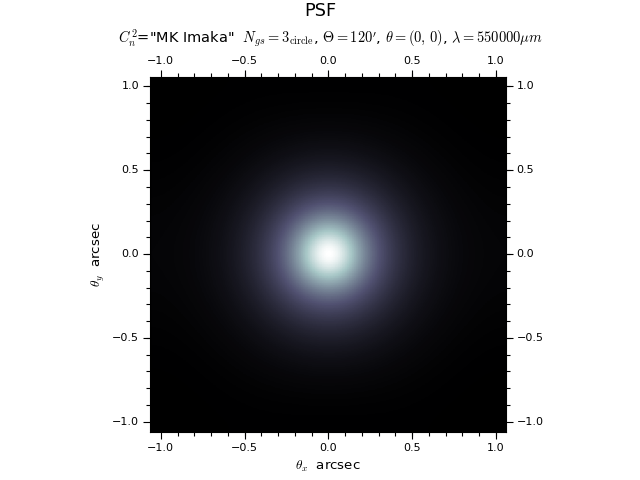

In [5]:
reload(p)
N = 3
g = 'circle'
r = 120. # arcmin
a = p.Cn2_Profile('MK Imaka')
fp = np.array([0.,0.])
a.make_PSF(w = [1./N,]*N,constellation=p.Constellation(ngs=N,geometry=g,radius=r),field_point=fp)
np.log(a.PSF).show()

In [7]:
a.PSF.pprint()

PSF
<class 'info_array.InfoArray'>
shape: (512, 512)
Cn2:    'MK Imaka'
axis_names:    ['$\\theta_x$', '$\\theta_y$']
dx:    0.00413953130632 arcsec
ena:    0.0952295935039 arcsec^2
ena_r:    0.174104913973 ENA radius, arcsec
name:    'PSF'
ngs:    3
plotParams:    <type 'dict'>
sub:    <type 'str'>
units:    ''


** Figure 2a ** GLAO corrected PSF at the center of the field. (MK Imaka $C_n^2$ profile)

<IPython.core.display.Javascript object>


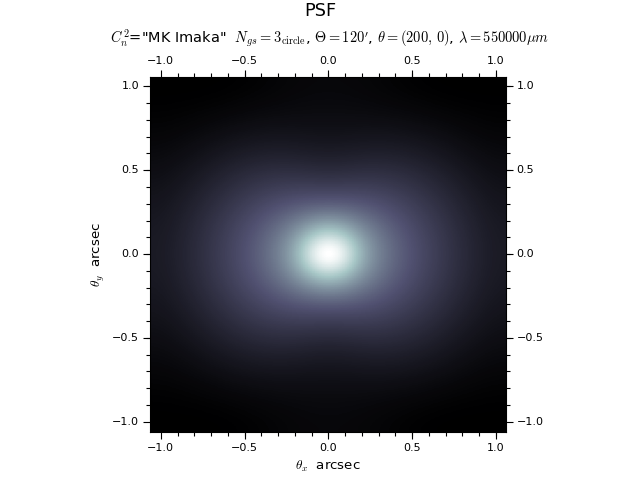

In [7]:
fp = np.array([200.,0.])
a.make_PSF(w = [1./N,]*N,constellation=p.Constellation(ngs=N,geometry=g,radius=r),field_point=fp)
np.log(a.PSF).show()

** Figure 2b ** GLAO corrected PSF past the edge of the constellation field.

<IPython.core.display.Javascript object>


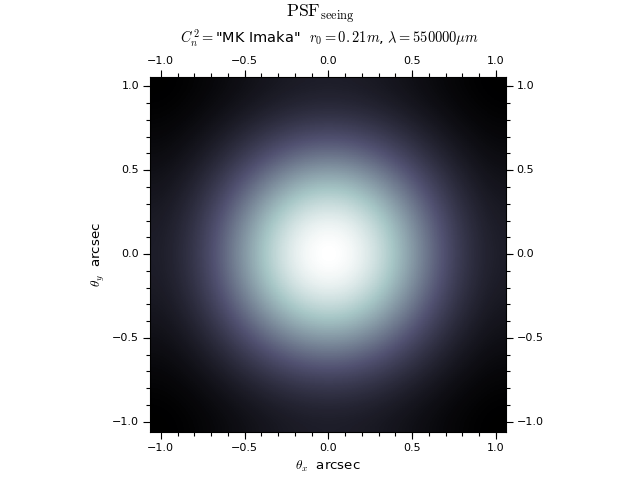

In [8]:
a.make_PSF0()
np.log(a.PSF_seeing).show()

** Figure 2c ** Uncorrected atmosphere PSF.

### GLAO Correction Factor

In [94]:
reload(p)
plt = p.plt

zc_set = [0.,100.,200.,-100.,-200.] # meters
FOV_set = [0.,.5,1.,1.5,2.,3.,4.,5.,6.,10] # arcmin
profile = 'MK Imaka'

def cycle(profile='MK Imaka',zc_set=zc_set,FOV_set=FOV_set):
    """cycle through the options and compute the FWHM improvement factor
    Returns:
        rs - a list of results, one per PSF calculation
             each result is a list with [model,zc,FOV,FWHM_seeing,FWHM,improvement]
    """
    a = p.Cn2_Profile(profile)
    print 'making seeing-limited PSF'
    a.make_PSF0()
    ngs = 4
    geom = 'wheel'
    w = [1./ngs,]*ngs
    r = []

    r = []
    for zc in zc_set:
        for fov in FOV_set:
            c = p.Constellation(ngs=ngs,geometry=geom,radius = fov, field_point=[fov*.9,0.])
            #print 'making PSF for FOV=%0.1f\', zc=%0.1fm'%(fov,zc)
            a.make_PSF(w,constellation=c,dm_conjugate=zc)
            #print p.fwhm2(a.PSF_seeing)[0]/p.fwhm2(a.PSF)[0]
            v1 = p.fwhm2(a.PSF)[0]*a.PSF.dx
            u1 = a.PSF.dx_units
            v2 = p.fwhm2(a.PSF_seeing)[0]*a.PSF_seeing.dx
            u2 = a.PSF_seeing.dx_units
            v3 = v2/v1
            print 'zc: %0.0f, FOV: %0.1f,  FWHM: PSF: %0.3f %s, PSF_seeing: %0.3f %s,  %0.1fx improvement'%(zc,fov,v1,u1,v2,u2,v3)
            r.append([profile,zc,fov,v1,v2,v3])

    return r


#### Examples of running the 'cycle(...)' code and its database results

In [95]:
profile = 'Simple 2h_100'
rs = cycle(profile)

making seeing-limited PSF
zc: 0, FOV: 0.0,  FWHM: PSF: 0.028 arcsec, PSF_seeing: 0.554 arcsec,  19.8x improvement
zc: 0, FOV: 0.5,  FWHM: PSF: 0.032 arcsec, PSF_seeing: 0.554 arcsec,  17.3x improvement
zc: 0, FOV: 1.0,  FWHM: PSF: 0.054 arcsec, PSF_seeing: 0.554 arcsec,  10.3x improvement
zc: 0, FOV: 1.5,  FWHM: PSF: 0.124 arcsec, PSF_seeing: 0.554 arcsec,  4.5x improvement
zc: 0, FOV: 2.0,  FWHM: PSF: 0.160 arcsec, PSF_seeing: 0.554 arcsec,  3.5x improvement
zc: 0, FOV: 3.0,  FWHM: PSF: 0.189 arcsec, PSF_seeing: 0.554 arcsec,  2.9x improvement
zc: 0, FOV: 4.0,  FWHM: PSF: 0.222 arcsec, PSF_seeing: 0.554 arcsec,  2.5x improvement
zc: 0, FOV: 5.0,  FWHM: PSF: 0.251 arcsec, PSF_seeing: 0.554 arcsec,  2.2x improvement
zc: 0, FOV: 6.0,  FWHM: PSF: 0.278 arcsec, PSF_seeing: 0.554 arcsec,  2.0x improvement
zc: 0, FOV: 10.0,  FWHM: PSF: 0.357 arcsec, PSF_seeing: 0.554 arcsec,  1.5x improvement
zc: 100, FOV: 0.0,  FWHM: PSF: 0.028 arcsec, PSF_seeing: 0.554 arcsec,  19.8x improvement
zc: 100, F

In [96]:
# save the results in a database
import pandas as pd
dfr = pd.DataFrame(columns=['model','z_c','fov','FWHM','FWHM_seeing','improvement'])
cols = dfr.columns
for result in rs:
    row = pd.Series(dict(zip(cols,result)))
    dfr = dfr.append(row,ignore_index=True)
dfr

model    z_c   fov      FWHM  FWHM_seeing  improvement
0   Simple 2h_100    0.0   0.0  0.028027     0.553774    19.758542
1   Simple 2h_100    0.0   0.5  0.031956     0.553774    17.329388
2   Simple 2h_100    0.0   1.0  0.053911     0.553774    10.271977
3   Simple 2h_100    0.0   1.5  0.124397     0.553774     4.451658
4   Simple 2h_100    0.0   2.0  0.159779     0.553774     3.465878
5   Simple 2h_100    0.0   3.0  0.189468     0.553774     2.922785
6   Simple 2h_100    0.0   4.0  0.222281     0.553774     2.491320
7   Simple 2h_100    0.0   5.0  0.250682     0.553774     2.209072
8   Simple 2h_100    0.0   6.0  0.278302     0.553774     1.989832
9   Simple 2h_100    0.0  10.0  0.357277     0.553774     1.549988
10  Simple 2h_100  100.0   0.0  0.028027     0.553774    19.758542
11  Simple 2h_100  100.0   0.5  0.028027     0.553774    19.758542
12  Simple 2h_100  100.0   1.0  0.047728     0.553774    11.602616
13  Simple 2h_100  100.0   1.5  0.107822     0.553774     5.135989
14  Simple 2h_100  100.0   2.0  0.144278     0.553774     3.838239
15  Simple 2h_100  100.0   3.0  0.178143     0.553774     3.108596
16  Simple 2h_100  100.0   4.0  0.198181     0.553774     2.794280
17  Simple 2h_100  100.0   5.0  0.214366     0.553774     2.583313
18  Simple 2h_100  100.0   6.0  0.231117     0.553774     2.396075
19  Simple 2h_100  100.0  10.0  0.287055     0.553774     1.929155
20  Simple 2h_100  200.0   0.0  0.028027     0.553774    19.758542
21  Simple 2h_100  200.0   0.5  0.028027     0.553774    19.758542
22  Simple 2h_100  200.0   1.0  0.045192     0.553774    12.253728
23  Simple 2h_100  200.0   1.5  0.099091     0.553774     5.588560
24  Simple 2h_100  200.0   2.0  0.144278     0.553774     3.838239
25  Simple 2h_100  200.0   3.0  0.196789     0.553774     2.814048
26  Simple 2h_100  200.0   4.0  0.234659     0.553774     2.359912
27  Simple 2h_100  200.0   5.0  0.268241     0.553774     2.064463
28  Simple 2h_100  200.0   6.0  0.295815     0.553774     1.872028
29  Simple 2h_100  200.0  10.0  0.377378     0.553774     1.467425
30  Simple 2h_100 -100.0   0.0  0.028027     0.553774    19.758542
31  Simple 2h_100 -100.0   0.5  0.031956     0.553774    17.329388
32  Simple 2h_100 -100.0   1.0  0.064523     0.553774     8.582562
33  Simple 2h_100 -100.0   1.5  0.142911     0.553774     3.874969
34  Simple 2h_100 -100.0   2.0  0.179242     0.553774     3.089536
35  Simple 2h_100 -100.0   3.0  0.241911     0.553774     2.289163
36  Simple 2h_100 -100.0   4.0  0.304581     0.553774     1.818151
37  Simple 2h_100 -100.0   5.0  0.355513     0.553774     1.557675
38  Simple 2h_100 -100.0   6.0  0.384799     0.553774     1.439127
39  Simple 2h_100 -100.0  10.0  0.452791     0.553774     1.223023
40  Simple 2h_100 -200.0   0.0  0.028027     0.553774    19.758542
41  Simple 2h_100 -200.0   0.5  0.031956     0.553774    17.329388
42  Simple 2h_100 -200.0   1.0  0.088629     0.553774     6.248200
43  Simple 2h_100 -200.0   1.5  0.170482     0.553774     3.248284
44  Simple 2h_100 -200.0   2.0  0.231117     0.553774     2.396075
45  Simple 2h_100 -200.0   3.0  0.337840     0.553774     1.639163
46  Simple 2h_100 -200.0   4.0  0.407695     0.553774     1.358304
47  Simple 2h_100 -200.0   5.0  0.437528     0.553774     1.265689
48  Simple 2h_100 -200.0   6.0  0.461214     0.553774     1.200689
49  Simple 2h_100 -200.0  10.0  0.496641     0.553774     1.115039

In [125]:
# merge with prior database
df = df.merge(dfr,how='outer')

In [126]:
df

model    z_c   fov  FWHM_seeing      FWHM  improvement
0         Simple 2    0.0   0.0     0.000000  0.000000    19.758542
1         Simple 2    0.0   0.5     0.000000  0.000000    17.329388
2         Simple 2    0.0   1.0     0.000000  0.000000    10.271977
3         Simple 2    0.0   1.5     0.000000  0.000000     4.463000
4         Simple 2    0.0   2.0     0.000000  0.000000     3.650237
5         Simple 2    0.0   3.0     0.000000  0.000000     3.108596
6         Simple 2    0.0   4.0     0.000000  0.000000     2.922785
7         Simple 2    0.0   5.0     0.000000  0.000000     2.794280
8         Simple 2    0.0   6.0     0.000000  0.000000     2.654606
9         Simple 2    0.0  10.0     0.000000  0.000000     2.359912
10        Simple 2  100.0   0.0     0.000000  0.000000    19.758542
11        Simple 2  100.0   0.5     0.000000  0.000000    19.758542
12        Simple 2  100.0   1.0     0.000000  0.000000    11.602616
13        Simple 2  100.0   1.5     0.000000  0.000000     4.792150
14        Simple 2  100.0   2.0     0.000000  0.000000     3.650237
15        Simple 2  100.0   3.0     0.000000  0.000000     2.828427
16        Simple 2  100.0   4.0     0.000000  0.000000     2.375209
17        Simple 2  100.0   5.0     0.000000  0.000000     1.998976
18        Simple 2  100.0   6.0     0.000000  0.000000     1.719109
19        Simple 2  100.0  10.0     0.000000  0.000000     1.171423
20        Simple 2  200.0   0.0     0.000000  0.000000    19.758542
21        Simple 2  200.0   0.5     0.000000  0.000000    19.758542
22        Simple 2  200.0   1.0     0.000000  0.000000    12.253728
23        Simple 2  200.0   1.5     0.000000  0.000000     5.135989
24        Simple 2  200.0   2.0     0.000000  0.000000     3.270457
25        Simple 2  200.0   3.0     0.000000  0.000000     2.064463
26        Simple 2  200.0   4.0     0.000000  0.000000     1.480965
27        Simple 2  200.0   5.0     0.000000  0.000000     1.224196
28        Simple 2  200.0   6.0     0.000000  0.000000     1.112914
29        Simple 2  200.0  10.0     0.000000  0.000000     0.960239
..             ...    ...   ...          ...       ...          ...
126  Simple 2h_100  200.0   0.0     0.553774  0.028027    19.758542
127  Simple 2h_100  200.0   0.5     0.553774  0.028027    19.758542
128  Simple 2h_100  200.0   1.0     0.553774  0.045192    12.253728
129  Simple 2h_100  200.0   1.5     0.553774  0.099091     5.588560
130  Simple 2h_100  200.0   2.0     0.553774  0.144278     3.838239
131  Simple 2h_100  200.0   3.0     0.553774  0.196789     2.814048
132  Simple 2h_100  200.0   4.0     0.553774  0.234659     2.359912
133  Simple 2h_100  200.0   5.0     0.553774  0.268241     2.064463
134  Simple 2h_100  200.0   6.0     0.553774  0.295815     1.872028
135  Simple 2h_100  200.0  10.0     0.553774  0.377378     1.467425
136  Simple 2h_100 -100.0   0.0     0.553774  0.028027    19.758542
137  Simple 2h_100 -100.0   0.5     0.553774  0.031956    17.329388
138  Simple 2h_100 -100.0   1.0     0.553774  0.064523     8.582562
139  Simple 2h_100 -100.0   1.5     0.553774  0.142911     3.874969
140  Simple 2h_100 -100.0   2.0     0.553774  0.179242     3.089536
141  Simple 2h_100 -100.0   3.0     0.553774  0.241911     2.289163
142  Simple 2h_100 -100.0   4.0     0.553774  0.304581     1.818151
143  Simple 2h_100 -100.0   5.0     0.553774  0.355513     1.557675
144  Simple 2h_100 -100.0   6.0     0.553774  0.384799     1.439127
145  Simple 2h_100 -100.0  10.0     0.553774  0.452791     1.223023
146  Simple 2h_100 -200.0   0.0     0.553774  0.028027    19.758542
147  Simple 2h_100 -200.0   0.5     0.553774  0.031956    17.329388
148  Simple 2h_100 -200.0   1.0     0.553774  0.088629     6.248200
149  Simple 2h_100 -200.0   1.5     0.553774  0.170482     3.248284
150  Simple 2h_100 -200.0   2.0     0.553774  0.231117     2.396075
151  Simple 2h_100 -200.0   3.0     0.553774  0.337840     1.639163
152  Simple 2h_100 -200.0   4.0     0.553774  0.407695     1.358304
1

### Plots

Contours of **PSF FWHM improvement factor**, ${\rm FWHM}_{\rm seeing} / {\rm FWHM}_{\rm AO}$, as a function of **DM conjugate altitude**, $z_c$, and **field angle**, $\Theta$.

In [10]:
def plot(df,model='MK Imaka'):
    dfs = df[df.model==model]
    title = model
    zc_set = np.array(dfs['z_c'].unique())
    
    # assign colors
    i0 = np.where(zc_set == 0)[0]
    ig = np.where(zc_set > 0)[0]
    il = np.where(zc_set < 0)[0]
    colors = ['k',]*len(zc_set)
    color_wheel = ['b','g','r','c','m']
    for i in ig:
        colors[i] = color_wheel[i%len(color_wheel)]
    for i in il:
        js = np.where(zc_set == -zc_set[i])[0]
        for j in js:
            colors[i] = colors[j]
    # done assigning colors
    
    plt.figure()
    for zc,color in zip(zc_set,colors):
        dfsi = dfs[dfs.z_c==zc].sort_values(by='improvement')
        if zc < 0:
            line = '--'
        else:
            line = '-'
        plt.plot(dfsi.improvement,dfsi.fov,color+line,label=r'$z_c$ = %0.1f'%zc)

    plt.title(title)
    plt.legend()
    plt.xlabel(r'Improvement factor ${\rm FWHM}_{\rm seeing} / {\rm FWHM}_{\rm AO}$')
    plt.ylabel(r'GLAO field radius $\Theta_{\rm GL}$, arcmin')
    plt.ylim(1,50)
    plt.xlim(0,10)
    plt.yscale('log')
    plt.grid('on',which='both')
    ax = plt.gca()
    from matplotlib.ticker import FormatStrFormatter
    majorFormatter = FormatStrFormatter('%d')
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_minor_formatter(majorFormatter)

def plot2(df,model='MK Imaka'):
    dfs = df[df.model==model]
    title = model

    plt.figure()
    x,y,z = dfs['z_c'],dfs['fov'],dfs['improvement']
    x,y,z = map(np.array,(x,y,z))
    xi = np.linspace(x.min(),x.max(),50)
    yi = np.linspace(y.min(),y.max(),50)
    zi = matplotlib.mlab.griddata(x,y,z,xi,yi,interp='linear')
    levels = [1.,1.5,2.,2.5,3.,4.,5.,7.,10.]
    cs = plt.contour(xi,yi,zi,levels,colors='k')
    plt.clabel(cs)
    plt.xlabel(r'DM Conjugate altitude, $z_c$, meters')
    plt.ylabel(r'GLAO corrected field radius, $\Theta_{\rm GL}$, arcmin')
    plt.grid('on')
    plt.title(title)

#### Mauna Kea Imaka profile

<IPython.core.display.Javascript object>


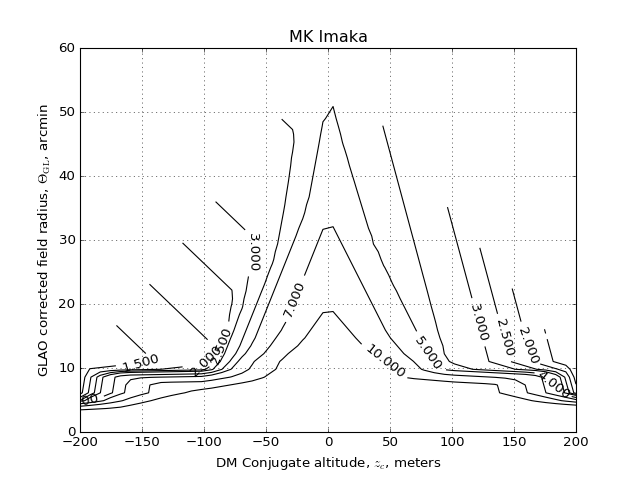

In [11]:
model = 'MK Imaka'
plot2(df,model)

#### 2-layer $C_n^2$ profiles with "ground layer" at different heights above ground

<IPython.core.display.Javascript object>


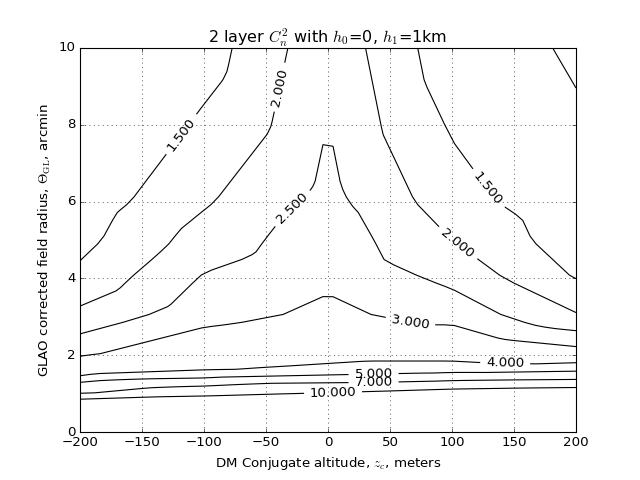

In [12]:
model = 'Simple 2'
plot2(df,model)
plt.title(r'2 layer $C_n^2$ with $h_0$=0, $h_1$=1km');

<IPython.core.display.Javascript object>


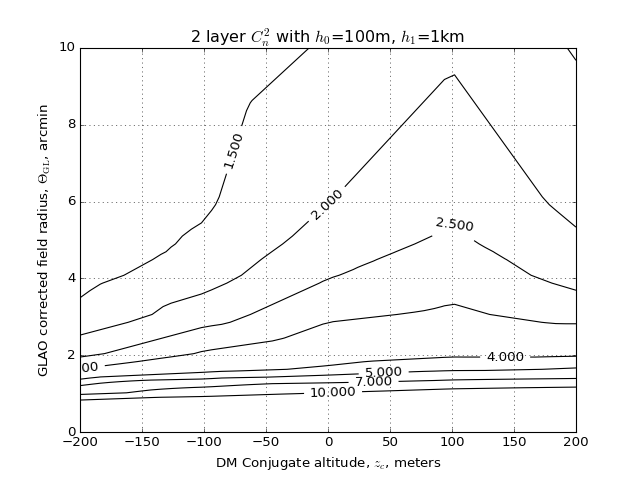

In [13]:
model = 'Simple 2h_100'
plot2(df,model)
plt.title(r'2 layer $C_n^2$ with $h_0$=100m, $h_1$=1km');

<IPython.core.display.Javascript object>


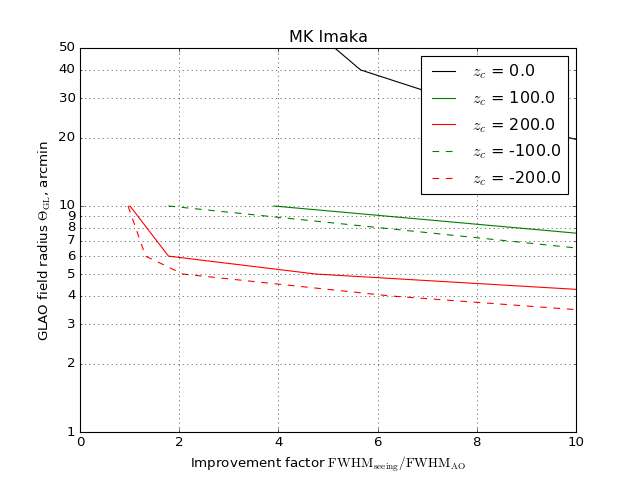

In [14]:
plot(df)

<IPython.core.display.Javascript object>


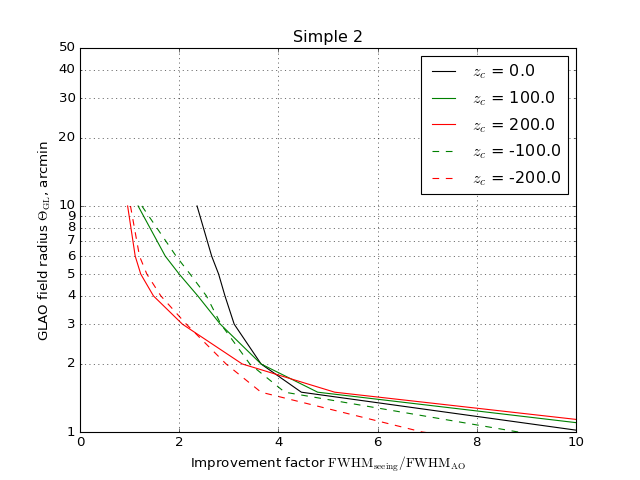

In [38]:
plot(df,model='Simple 2')

<hr style='height: 2px; border-top: 3px double;'/>
## Support code for handling databases
<hr style='height: 2px;'/>
#### Read in a saved database


In [4]:
import pandas as pd
store = pd.HDFStore('paper2.hd5')
df = store['df']
df.metadata = store.get_storer('df').attrs.metadata
dflo = store['dflo']
dflo.metadata = store.get_storer('dflo').attrs.metadata
store.close()

In [5]:
print dflo.metadata
dflo

{'descr': 'MTF and PSF lineouts for various star constellations', 'time': '2017/04/27T12:04:59'}


model    curve  csize  N   nx  \
0  MK Imaka     GLAO     10  3  256   
1  MK Imaka     GLAO     20  3  256   
2  MK Imaka     GLAO     40  3  256   
3  MK Imaka     GLAO     50  3  256   
4  MK Imaka     GLAO    120  3  256   
5  MK Imaka   seeing      0  0  256   
6   diffLim  diffLim      0  0  256   

                                                 mtf  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                   u  \
0  [-6.85135798241, -6.79783174817, -6.7443055139...   
1  [-6.85135798241, -6.79783174817, -6.7443055139...   
2  [-6.85135798241, -6.79783174817, -6.7443055139...   
3  [-6.85135798241, -6.79783174817, -6.7443055139...   
4  [-6.85135798241, -6.79783174817, -6.7443055139...   
5  [-6.85135798241, -6.79783174817, -6.7443055139...   
6  [-6.85135798241, -6.79783174817, -6.7443055139...   

                                                 psf  \
0  [7.72542764764e-06, 7.87158817729e-06, 7.92447...   
1  [2.53412146079e-05, 2.54976065133e-05, 2.56957...   
2  [0.000118728089643, 0.000118757295703, 0.00011...   
3  [0.00016928650424, 0.000169282419178, 0.000169...   
4  [0.000583524184371, 0.000583582509679, 0.00058...   
5  [0.00777987458805, 0.00778514734204, 0.0078009...   
6  [1.70939247218e-06, 1.86360636149e-06, 1.93177...   

                                               theta  
0  [-1.05972001442, -1.0514409518, -1.04316188919...  
1  [-1.05972001442, -1.0514409518, -1.04316188919...  
2  [-1.05972001442, -1.0514409518, -1.04316188919...  
3  [-1.05972001442, -1.0514409518, -1.04316188919...  
4  [-1.05972001442, -1.0514409518, -1.04316188919...  
5  [-1.05972001442, -1.0514409518, -1.04316188919...  
6  [-1.05972001442, -1.0514409518, -1.04316188919...

In [99]:
print df.metadata
df

{'descr': 'FWHM improvement factors for various star constellations and DM conjugates', 'time': '2017/04/27T12:09:43'}


model    z_c   fov  FWHM_seeing      FWHM  improvement
0         Simple 2    0.0   0.0     0.000000  0.000000    19.758542
1         Simple 2    0.0   0.5     0.000000  0.000000    17.329388
2         Simple 2    0.0   1.0     0.000000  0.000000    10.271977
3         Simple 2    0.0   1.5     0.000000  0.000000     4.463000
4         Simple 2    0.0   2.0     0.000000  0.000000     3.650237
5         Simple 2    0.0   3.0     0.000000  0.000000     3.108596
6         Simple 2    0.0   4.0     0.000000  0.000000     2.922785
7         Simple 2    0.0   5.0     0.000000  0.000000     2.794280
8         Simple 2    0.0   6.0     0.000000  0.000000     2.654606
9         Simple 2    0.0  10.0     0.000000  0.000000     2.359912
10        Simple 2  100.0   0.0     0.000000  0.000000    19.758542
11        Simple 2  100.0   0.5     0.000000  0.000000    19.758542
12        Simple 2  100.0   1.0     0.000000  0.000000    11.602616
13        Simple 2  100.0   1.5     0.000000  0.000000     4.792150
14        Simple 2  100.0   2.0     0.000000  0.000000     3.650237
15        Simple 2  100.0   3.0     0.000000  0.000000     2.828427
16        Simple 2  100.0   4.0     0.000000  0.000000     2.375209
17        Simple 2  100.0   5.0     0.000000  0.000000     1.998976
18        Simple 2  100.0   6.0     0.000000  0.000000     1.719109
19        Simple 2  100.0  10.0     0.000000  0.000000     1.171423
20        Simple 2  200.0   0.0     0.000000  0.000000    19.758542
21        Simple 2  200.0   0.5     0.000000  0.000000    19.758542
22        Simple 2  200.0   1.0     0.000000  0.000000    12.253728
23        Simple 2  200.0   1.5     0.000000  0.000000     5.135989
24        Simple 2  200.0   2.0     0.000000  0.000000     3.270457
25        Simple 2  200.0   3.0     0.000000  0.000000     2.064463
26        Simple 2  200.0   4.0     0.000000  0.000000     1.480965
27        Simple 2  200.0   5.0     0.000000  0.000000     1.224196
28        Simple 2  200.0   6.0     0.000000  0.000000     1.112914
29        Simple 2  200.0  10.0     0.000000  0.000000     0.960239
..             ...    ...   ...          ...       ...          ...
126  Simple 2h_100  200.0   0.0     0.553774  0.028027    19.758542
127  Simple 2h_100  200.0   0.5     0.553774  0.028027    19.758542
128  Simple 2h_100  200.0   1.0     0.553774  0.045192    12.253728
129  Simple 2h_100  200.0   1.5     0.553774  0.099091     5.588560
130  Simple 2h_100  200.0   2.0     0.553774  0.144278     3.838239
131  Simple 2h_100  200.0   3.0     0.553774  0.196789     2.814048
132  Simple 2h_100  200.0   4.0     0.553774  0.234659     2.359912
133  Simple 2h_100  200.0   5.0     0.553774  0.268241     2.064463
134  Simple 2h_100  200.0   6.0     0.553774  0.295815     1.872028
135  Simple 2h_100  200.0  10.0     0.553774  0.377378     1.467425
136  Simple 2h_100 -100.0   0.0     0.553774  0.028027    19.758542
137  Simple 2h_100 -100.0   0.5     0.553774  0.031956    17.329388
138  Simple 2h_100 -100.0   1.0     0.553774  0.064523     8.582562
139  Simple 2h_100 -100.0   1.5     0.553774  0.142911     3.874969
140  Simple 2h_100 -100.0   2.0     0.553774  0.179242     3.089536
141  Simple 2h_100 -100.0   3.0     0.553774  0.241911     2.289163
142  Simple 2h_100 -100.0   4.0     0.553774  0.304581     1.818151
143  Simple 2h_100 -100.0   5.0     0.553774  0.355513     1.557675
144  Simple 2h_100 -100.0   6.0     0.553774  0.384799     1.439127
145  Simple 2h_100 -100.0  10.0     0.553774  0.452791     1.223023
146  Simple 2h_100 -200.0   0.0     0.553774  0.028027    19.758542
147  Simple 2h_100 -200.0   0.5     0.553774  0.031956    17.329388
148  Simple 2h_100 -200.0   1.0     0.553774  0.088629     6.248200
149  Simple 2h_100 -200.0   1.5     0.553774  0.170482     3.248284
150  Simple 2h_100 -200.0   2.0     0.553774  0.231117     2.396075
151  Simple 2h_100 -200.0   3.0     0.553774  0.337840     1.639163
152  Simple 2h_100 -200.0   4.0     0.553774  0.407695     1.358304
1

#### move data from one database to another

In [87]:
# re-write this data table into the 'paper2.hd5' file
import time
store = pd.HDFStore('paper2.hd5')
metadata = {'descr':'FWHM improvement factors for various star constellations and DM conjugates',
           'time':time.strftime('%Y/%m/%dT%H:%M:%S')}
if 'df' in store:
    print 'WARNING: dflo is already in the store. opting to not over-write'
else:
    store['df'] = df
    store.get_storer('df').attrs.metadata = metadata
store.close()

#### What's currently in the database

In [3]:
import pandas as pd
store = pd.HDFStore('paper2.hd5')
for key in store.keys():
    print key
    try:
        metadata = store.get_storer(key).attrs.metadata
        for k in metadata.keys():
            print ' '*4,metadata[k]
    except:
        pass
        
store.close()

/df
     FWHM improvement factors for various star constellations and DM conjugates
     2017/04/27T12:09:43
/dflo
     MTF and PSF lineouts for various star constellations
     2017/04/27T12:04:59


#### Write out the newly merged database

In [128]:
#store = pd.HDFStore('store.h5')
#store['df'] = df
#store['df']
#store.close()